<a href="https://colab.research.google.com/github/sjamillah/Formative-2_Data-Preprocessing_Group-9/blob/main/Formative_2_Group_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [158]:
df = pd.read_csv('/content/customer_transactions.csv')
df.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


## **Handling Missing Values**

In [159]:
print(df.isnull().sum())

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


## Imputation

In [160]:
imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

df['customer_rating'] = imputer_mean.fit_transform(df[['customer_rating']])
df['purchase_amount'] = imputer_median.fit_transform(df[['purchase_amount']])

In [161]:
print(df.isnull().sum())

customer_id_legacy    0
transaction_id        0
purchase_amount       0
purchase_date         0
product_category      0
customer_rating       0
dtype: int64


## Data Augmentation Techniques

1. Data Expansion

In [162]:
print("\nApplying random noise to purchase amounts...")
np.random.seed(42)
df['purchase_amount_augmented'] = df['purchase_amount'] * (1 + np.random.uniform(-0.05, 0.05, df.shape[0]))


Applying random noise to purchase amounts...


2. Feature Value Transformation

In [163]:
print("Applying log transformation...")
df['log_purchase_amount'] = np.log1p(df['purchase_amount_augmented'])

Applying log transformation...


3. Synthetic Transformations

In [164]:
num_new_rows = 500
new_transactions = df.sample(n=num_new_rows, replace=True).copy()
new_transactions['purchase_amount_augmented'] *= np.random.uniform(0.9, 1.1, num_new_rows)
new_transactions['transaction_id'] = np.arange(df['transaction_id'].max() + 1,
                                             df['transaction_id'].max() + 1 + num_new_rows)

df_augmented = pd.concat([df, new_transactions], ignore_index=True)

In [165]:
if 'product_category' in df_augmented.columns:
  print("\nApplying SMOTE to balance dataset based on product category...")
  le_category = LabelEncoder()
  df_augmented['product_category_encoded'] = le_category.fit_transform(df_augmented['product_category'])

  X_features = df_augmented[['purchase_amount', 'customer_rating']]
  y_target = df_augmented['product_category_encoded']

  smote = SMOTE(random_state=42)
  X_smote, y_smote = smote.fit_resample(X_features, y_target)

  balanced_df = pd.DataFrame(X_smote, columns=['purchase_amount', 'customer_rating'])
  balanced_df['product_category'] = le_category.inverse_transform(y_smote)

  customer_ids = df_augmented['customer_id_legacy'].sample(len(balanced_df), replace=True).reset_index(drop=True)
  balanced_df['customer_id_legacy'] = customer_ids
  balanced_df['transaction_id'] = np.arange(1, len(balanced_df) + 1)
  balanced_df['purchase_amount_augmented'] = balanced_df['purchase_amount'] * (1 + np.random.uniform(-0.05, 0.05, len(balanced_df)))
  balanced_df['log_purchase_amount'] = np.log1p(balanced_df['purchase_amount_augmented'])

  df_augmented = balanced_df
  print(f"Dataset after SMOTE balancing: {df_augmented.shape}")


Applying SMOTE to balance dataset based on product category...
Dataset after SMOTE balancing: (745, 7)


In [166]:
df_augmented.to_csv("customer_transactions_augmented.csv", index=False)
print("Augmented dataset saved successfully!")

Augmented dataset saved successfully!


In [167]:
df_augmented.head()

,purchase_amount,customer_rating,product_category,customer_id_legacy,transaction_id,purchase_amount_augmented,log_purchase_amount
0,408.0,2.3,Sports,128,1,400.555283,5.995345
1,332.0,4.2,Electronics,135,2,347.032878,5.852297
2,442.0,2.1,Electronics,108,3,456.373874,6.125501
3,256.0,2.8,Clothing,135,4,260.257456,5.565506
4,64.0,1.3,Clothing,188,5,61.579276,4.136434


## Part 2: Merging Datasets

In [168]:
transactions_df = pd.read_csv("customer_transactions_augmented.csv")
social_profiles_df = pd.read_csv("customer_social_profiles.csv")
id_mapping_df = pd.read_csv("id_mapping.csv")

print(f"Transactions dataset shape: {transactions_df.shape}")
print(f"Social profiles dataset shape: {social_profiles_df.shape}")
print(f"ID mapping dataset shape: {id_mapping_df.shape}")

Transactions dataset shape: (745, 7)
Social profiles dataset shape: (155, 5)
ID mapping dataset shape: (155, 2)


In [169]:
merged_with_mapping = pd.merge(transactions_df, id_mapping_df, how='left', left_on='customer_id_legacy', right_on='customer_id_legacy')
final_merged_df = pd.merge(merged_with_mapping, social_profiles_df, how='left', left_on='customer_id_new', right_on='customer_id_new')

print("\nColumns in merged dataset:")
print(final_merged_df.columns)


Columns in merged dataset:
Index(['purchase_amount', 'customer_rating', 'product_category',
       'customer_id_legacy', 'transaction_id', 'purchase_amount_augmented',
       'log_purchase_amount', 'customer_id_new', 'social_media_platform',
       'engagement_score', 'purchase_interest_score', 'review_sentiment'],
      dtype='object')


In [170]:
final_merged_df['customer_engagement_score'] = 0.0
mask = ~final_merged_df['engagement_score'].isna() & ~final_merged_df['purchase_amount'].isna()

if mask.any():
    max_purchase = final_merged_df.loc[mask, 'purchase_amount'].max()
    max_engagement = final_merged_df.loc[mask, 'engagement_score'].max()

    if max_purchase > 0 and max_engagement > 0:
        final_merged_df.loc[mask, 'customer_engagement_score'] = (
            0.6 * final_merged_df.loc[mask, 'engagement_score'] / max_engagement +
            0.4 * final_merged_df.loc[mask, 'purchase_amount'] / max_purchase
        )

In [171]:
if 'purchase_date' in final_merged_df.columns:
    print("Creating time-based features...")
    final_merged_df['purchase_date'] = pd.to_datetime(final_merged_df['purchase_date'], errors='coerce')

    final_merged_df.sort_values(['customer_id_legacy', 'purchase_date'], inplace=True)

    final_merged_df['moving_avg_3'] = final_merged_df.groupby('customer_id_legacy')['purchase_amount'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

    final_merged_df['first_purchase_date'] = final_merged_df.groupby('customer_id_legacy')['purchase_date'].transform('min')
    final_merged_df['days_since_first_purchase'] = (final_merged_df['purchase_date'] - final_merged_df['first_purchase_date']).dt.days

In [172]:
if 'product_category' in final_merged_df.columns:
    print("Creating category-based features...")

    category_avg = final_merged_df.groupby('product_category')['purchase_amount'].transform('mean')
    final_merged_df['category_purchase_ratio'] = final_merged_df['purchase_amount'] / category_avg

    category_dummies = pd.get_dummies(final_merged_df['product_category'], prefix='category')
    final_merged_df = pd.concat([final_merged_df, category_dummies], axis=1)

Creating category-based features...


In [173]:
final_merged_df.to_csv("final_customer_data_group_9.csv", index=False)
print("Final merged dataset saved successfully!")

Final merged dataset saved successfully!


In [174]:
final_merged_df.head()

,purchase_amount,customer_rating,product_category,customer_id_legacy,transaction_id,purchase_amount_augmented,log_purchase_amount,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,customer_engagement_score,category_purchase_ratio,category_Books,category_Clothing,category_Electronics,category_Groceries,category_Sports
0,408.0,2.3,Sports,128,1,400.555283,5.995345,A132,LinkedIn,63.0,3.3,Positive,0.711515,1.388419,False,False,False,False,True
1,408.0,2.3,Sports,128,1,400.555283,5.995345,A165,LinkedIn,86.0,1.5,Positive,0.850909,1.388419,False,False,False,False,True
2,408.0,2.3,Sports,128,1,400.555283,5.995345,A172,TikTok,56.0,2.7,Negative,0.669091,1.388419,False,False,False,False,True
3,408.0,2.3,Sports,128,1,400.555283,5.995345,A149,Facebook,51.0,1.3,Positive,0.638788,1.388419,False,False,False,False,True
4,408.0,2.3,Sports,128,1,400.555283,5.995345,A191,Facebook,92.0,2.1,Positive,0.887273,1.388419,False,False,False,False,True


# Part 3: Data Consistency and Quality Checks

In [175]:
duplicates = final_merged_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("Removing duplicate entries...")
    final_merged_df.drop_duplicates(inplace=True)

Number of duplicate rows: 90
Removing duplicate entries...


In [176]:
print("\nChecking categorical values...")
if 'review_sentiment' in final_merged_df.columns:
    unique_values = final_merged_df['review_sentiment'].unique()
    print(f"Unique values in 'review_sentiment': {unique_values}")

    final_merged_df['review_sentiment'] = final_merged_df['review_sentiment'].replace('None', 'Neutral')
    final_merged_df['review_sentiment'] = final_merged_df['review_sentiment'].fillna('Neutral')


Checking categorical values...
Unique values in 'review_sentiment': ['Positive' 'Negative' 'Neutral' nan]


In [177]:
if 'social_media_platform' in final_merged_df.columns:
    missing_profiles = final_merged_df[final_merged_df['social_media_platform'].isna()]
    print(f"Number of records missing social media profiles: {len(missing_profiles)}")

    if len(missing_profiles) > 0:
        print("Filling missing social media platform values with 'Unknown'")
        final_merged_df['social_media_platform'] = final_merged_df['social_media_platform'].fillna('Unknown')

Number of records missing social media profiles: 363
Filling missing social media platform values with 'Unknown'


In [178]:
print(final_merged_df.describe())

       purchase_amount  customer_rating  customer_id_legacy  transaction_id  \
count      1851.000000      1851.000000         1851.000000     1851.000000   
mean        283.364134         2.909841          153.152890      373.188547   
std         116.236218         1.154867           31.019486      214.826222   
min          51.000000         1.000000          100.000000        1.000000   
25%         179.000000         1.800000          132.000000      190.500000   
50%         280.000000         2.985000          152.000000      370.000000   
75%         387.000000         3.900000          180.000000      559.500000   
max         495.000000         5.000000          199.000000      745.000000   

       purchase_amount_augmented  log_purchase_amount  engagement_score  \
count                1851.000000          1851.000000       1488.000000   
mean                  283.873187             5.549513         77.604839   
std                   116.717774             0.484193         1

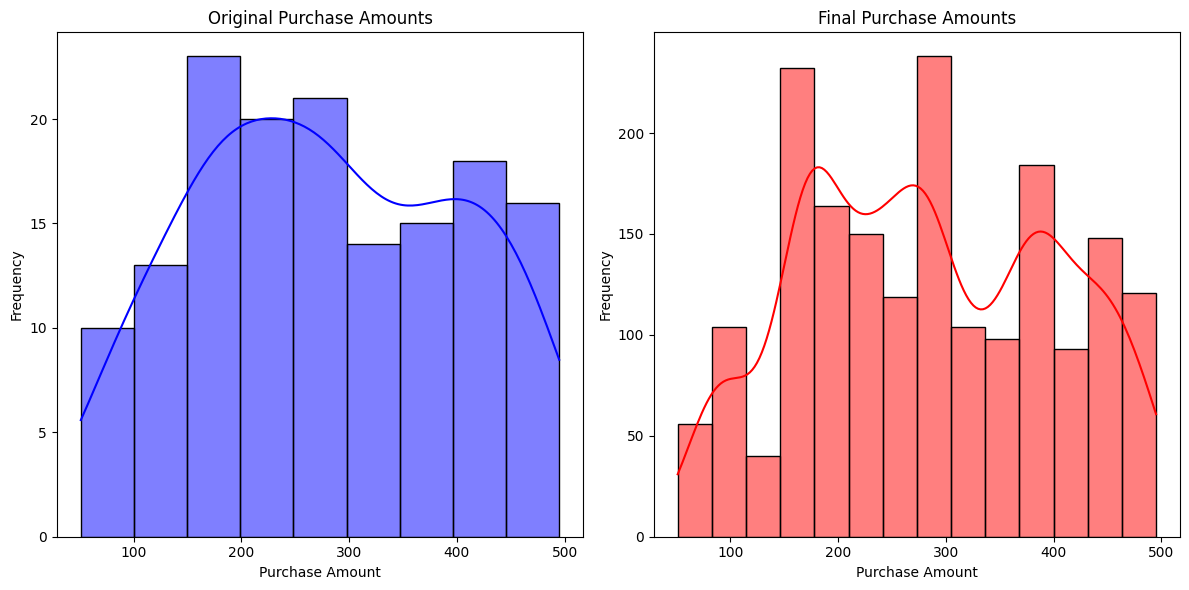

In [179]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['purchase_amount'], kde=True, color='blue')
plt.title('Original Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(final_merged_df['purchase_amount'], kde=True, color='red')
plt.title('Final Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

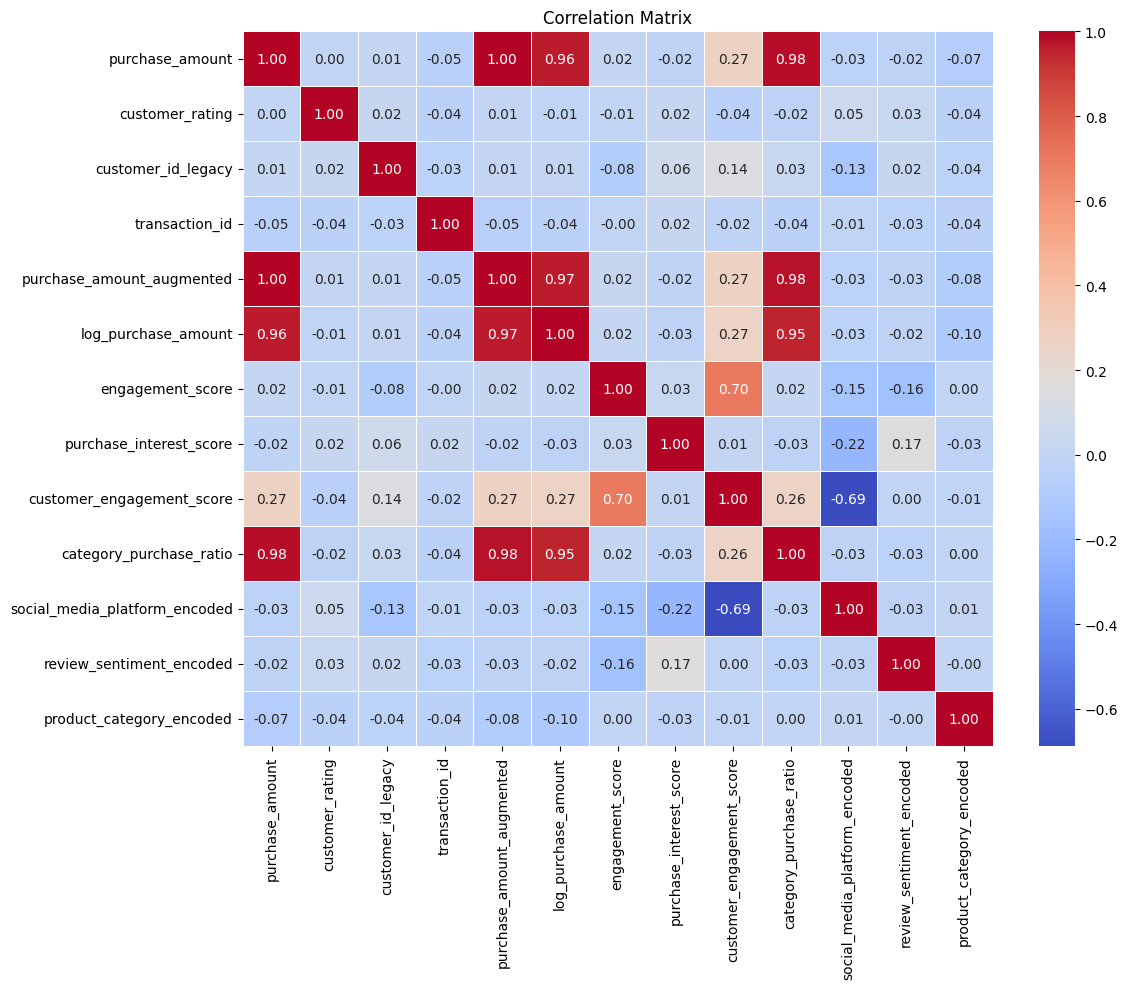

In [180]:
le_dict = {}
categorical_cols = ['social_media_platform', 'review_sentiment', 'product_category']
for col in categorical_cols:
    if col in final_merged_df.columns:
        le = LabelEncoder()
        final_merged_df[f'{col}_encoded'] = le.fit_transform(final_merged_df[col].astype(str))
        le_dict[col] = le

numeric_cols = final_merged_df.select_dtypes(include=['number']).columns
correlation_matrix = final_merged_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [181]:
X = final_merged_df.select_dtypes(include=['number'])
if 'purchase_amount' in X.columns:
    X = X.drop(['purchase_amount'], axis=1)
y = final_merged_df['purchase_amount']

imputer_X = SimpleImputer(strategy='median')

X_imputed = imputer_X.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new = selector.fit_transform(X_imputed, y)

top_features = X.columns[selector.get_support()]
print("Top 10 Features:", top_features)

Top 10 Features: Index(['customer_rating', 'customer_id_legacy', 'transaction_id',
       'purchase_amount_augmented', 'log_purchase_amount',
       'purchase_interest_score', 'customer_engagement_score',
       'category_purchase_ratio', 'review_sentiment_encoded',
       'product_category_encoded'],
      dtype='object')


In [182]:
selected_features_df = final_merged_df[list(top_features) + ['purchase_amount']]

In [183]:
final_merged_df.to_csv('final_dataset_ready_group_9.csv', index=False)

# Bonus Model

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(1480, 12), y=(1480,)
Test set shape: X=(371, 12), y=(371,)


In [185]:
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


Training Random Forest Regressor...


RandomForestRegressor(random_state=42)

In [186]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training: MAE={train_mae:.2f}, RMSE={train_rmse:.2f}, R²={train_r2:.4f}")
print(f"Testing: MAE={test_mae:.2f}, RMSE={test_rmse:.2f}, R²={test_r2:.4f}")


Model Performance:
Training: MAE=0.33, RMSE=0.86, R²=0.9999
Testing: MAE=1.12, RMSE=3.20, R²=0.9992


In [187]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                          Feature  Importance
3       purchase_amount_augmented    0.530865
4             log_purchase_amount    0.461466
8         category_purchase_ratio    0.006104
0                 customer_rating    0.000793
11       product_category_encoded    0.000405
2                  transaction_id    0.000150
1              customer_id_legacy    0.000150
7       customer_engagement_score    0.000027
6         purchase_interest_score    0.000020
5                engagement_score    0.000009
9   social_media_platform_encoded    0.000007
10       review_sentiment_encoded    0.000004


<ipython-input-188-21265f3f44d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


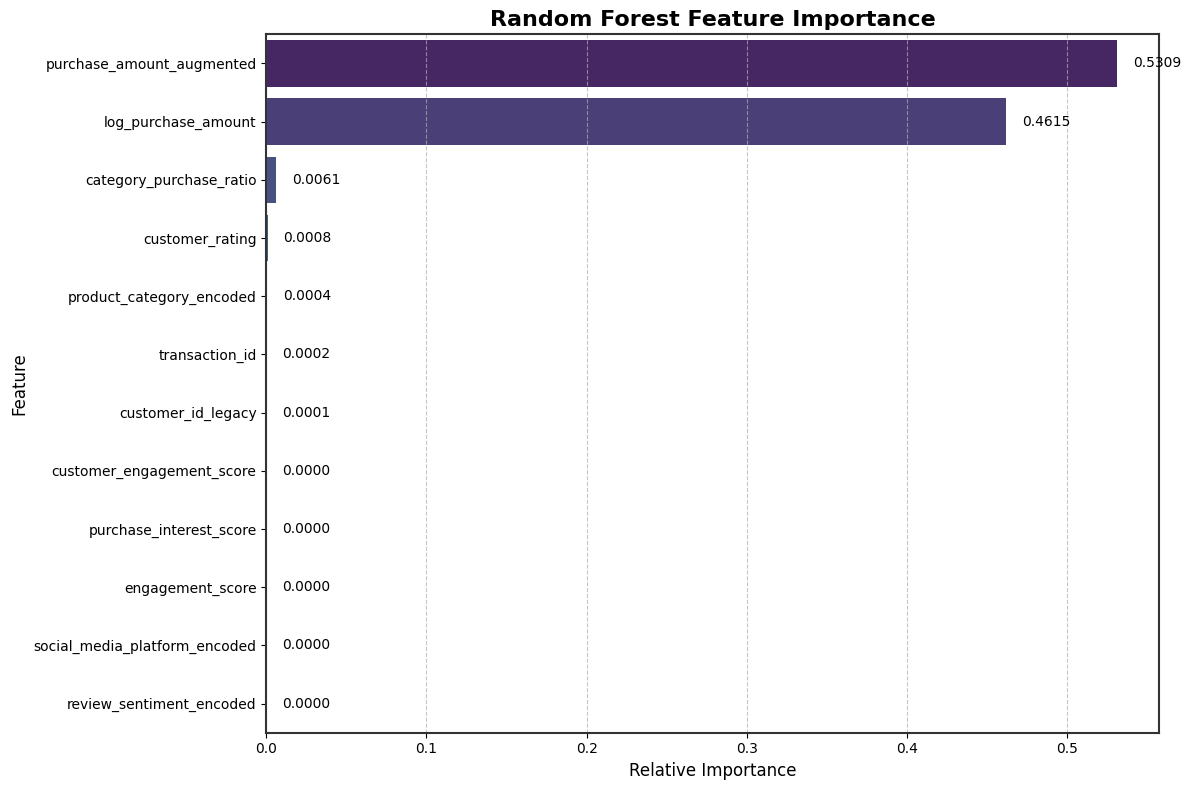

In [188]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance,
    palette='viridis'
)

for i, v in enumerate(feature_importance['Importance']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('#333333')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()